# Flickr8k

### Library

In [1]:
!pip install timm
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.9 MB/s eta 0:00:00


In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import itertools
from tqdm.autonotebook import tqdm
import albumentations as A
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
import timm
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer

<ipython-input-2-aecb6eba62dd>:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Download dataset
You should have a kaggle account

In [3]:
!pip install kaggle --upgrade
os.environ['KAGGLE_USERNAME'] = "danialalizadeh"
os.environ['KAGGLE_KEY'] = "9d2f61e8f2005686e33c7c9032eaf340"

!kaggle datasets download -d adityajn105/flickr8k
!unzip flickr8k.zip
dataset = "8k"

Streaming output truncated to the last 5000 lines.
  inflating: Images/2844846111_8c1cbfc75d.jpg  
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed

## Some pre-preocessing

In [4]:
if dataset == "8k":
  df = pd.read_csv("captions.txt")
  df['id'] = [id_ for id_ in range(df.shape[0] // 5) for _ in range(5)]
  df.to_csv("captions.csv", index=False)
  df = pd.read_csv("captions.csv")
  image_path = "/content/Images"
  captions_path = "/content"
df.head()

,image,caption,id
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,0
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,0
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,0
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,0
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,0


## Config

In [5]:
class CFG:
    debug = False
    image_path = image_path
    captions_path = captions_path
    batch_size = 32
    num_workers = 2
    head_lr = 1e-3
    image_encoder_lr = 1e-4
    text_encoder_lr = 1e-5
    weight_decay = 1e-3
    patience = 1
    factor = 0.8
    epochs = 4
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model_name = 'resnet50'
    image_embedding = 2048
    text_encoder_model = "distilbert-base-uncased"
    text_embedding = 768
    text_tokenizer = "distilbert-base-uncased"
    max_length = 200

    pretrained = True # for both image encoder and text encoder
    trainable = True # for both image encoder and text encoder
    temperature = 1.0

    # image size
    size = 224

    # for projection head; used for both image and text encoders
    projection_dim = 128
    dropout = 0.1

## Utils

In [6]:
class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]


## Dataset

The dataset returns images and encoded captions as a dictionary.

In [7]:
class CLIPDataset(torch.utils.data.Dataset):
    def __init__(self, image_filenames, captions, tokenizer, transforms):
        """
        image_filenames and cpations must have the same length; so, if there are
        multiple captions for each image, the image_filenames must have repetitive
        file names
        """

        self.image_filenames = image_filenames
        self.captions = list(captions)
        self.encoded_captions = tokenizer(
            list(captions), padding=True, truncation=True, max_length=CFG.max_length
        )
        self.transforms = transforms

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_captions.items()
        }

        image = cv2.imread(f"{CFG.image_path}/{self.image_filenames[idx]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transforms(image=image)['image']
        item['image'] = torch.tensor(image).permute(2, 0, 1).float()
        item['caption'] = self.captions[idx]

        return item


    def __len__(self):
        return len(self.captions)



def get_transforms(mode="train"):
    if mode == "train":
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )
    else:
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )

## Image Encoder

We use the timm library, which comprises numerous pre-trained image models. It returns a tensor of size 2048 for each image.

In [8]:
class ImageEncoder(nn.Module):
    """
    Encode images to a fixed size vector
    """

    def __init__(
        self, model_name=CFG.model_name, pretrained=CFG.pretrained, trainable=CFG.trainable
    ):
        super().__init__()
        self.model = timm.create_model(
            model_name, pretrained, num_classes=0, global_pool="avg"
        )
        for p in self.model.parameters():
            p.requires_grad = trainable

    def forward(self, x):
        return self.model(x)

## Text Encoder (TO DO)

We utilize the DistilBertModel from HuggingFace Transformers, which generates a 756-size vector for each input token (word). Similar to the original Bert model, the CLS token embedding is use to represent the entire caption.

In [9]:
class TextEncoder(nn.Module):
    def __init__(self, model_name=CFG.text_encoder_model, pretrained=CFG.pretrained, trainable=CFG.trainable):
        super().__init__()
        if pretrained:
            self.model = DistilBertModel.from_pretrained(model_name)
        else:
            self.model = DistilBertModel(config=DistilBertConfig())

        for p in self.model.parameters():
            p.requires_grad = trainable

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state # This is an tensor of size (BATCH_SIZE, num_words, 756)

        # ### TO DO: Just one Line ###
        # ### You shoud return the embeding of the CLS token. CLS token index is self.target_token_idx
        return last_hidden_state[:, self.target_token_idx, :]

## Projection Head (TO DO)

After encoding both images and texts into fixed-size vectors of 2048 and 768 dimensions respectively, we need to project them onto a new space. This new world space to have similar dimensions for both image and text vectors so that we can compare them. By doing so, we can segregate non-relevant image and text vectors and pull together those that match. To achieve this, we use a code that projects the 2048 and 768 dimensional vectors into a 128 dimensional space, where we can easily compare them.

Two instances of this class will be created to project image and text vectors.

In [10]:
class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim, # the size of the input vector (2048 for images and 768 for texts)
        projection_dim=CFG.projection_dim, #  the the size of the output vector (Use 128)
        dropout=CFG.dropout
    ):

        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)

    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

## CLIP: Putting it all to gather (TO DO)

This class encompasses all the logic behind CLIP. It projects images and text into a 128-dimensional space and computes the loss function.

In [11]:
class CLIPModel(nn.Module):
    def __init__(
        self,
        temperature=CFG.temperature,
        image_embedding=CFG.image_embedding,
        text_embedding=CFG.text_embedding,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature

    def forward(self, batch):
        # Getting Image and Text Features
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )

        ### TO DO ###
        ### Project both features into 128-dimensional space using above defined ProjectionHeads
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)

        ### TO DO ###
        ### Calculate loss and return it. You can set the temperature parameter to 1. (See figure 2 of the homework)
        logits = (text_embeddings @ image_embeddings.T) / self.temperature
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = F.softmax(
            (images_similarity + texts_similarity) / 2 * self.temperature, dim=-1
        )
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        return loss.mean()


def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

## Train

Here are some funtions to help us load train and valid dataloaders, our model and then train and evaluate our model on those. There's not much going on here; just simple training loop and utility functions

In [12]:
def make_train_valid_dfs():
    dataframe = pd.read_csv(f"{CFG.captions_path}/captions.csv")
    max_id = dataframe["id"].max() + 1 if not CFG.debug else 100
    image_ids = np.arange(0, max_id)
    np.random.seed(42)
    valid_ids = np.random.choice(
        image_ids, size=int(0.2 * len(image_ids)), replace=False
    )
    train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
    train_dataframe = dataframe[dataframe["id"].isin(train_ids)].reset_index(drop=True)
    valid_dataframe = dataframe[dataframe["id"].isin(valid_ids)].reset_index(drop=True)
    return train_dataframe, valid_dataframe


def build_loaders(dataframe, tokenizer, mode):
    transforms = get_transforms(mode=mode)
    dataset = CLIPDataset(
        dataframe["image"].values,
        dataframe["caption"].values,
        tokenizer=tokenizer,
        transforms=transforms,
    )
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        shuffle=True if mode == "train" else False,
    )
    return dataloader

Here's a handy function to train our model. There's not much happening here; just loading the batches, feeding them to the model and stepping the optimizer and lr_scheduler.

In [13]:
def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
    return loss_meter


def valid_epoch(model, valid_loader):
    loss_meter = AvgMeter()

    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter


def main():
    train_df, valid_df = make_train_valid_dfs()
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    train_loader = build_loaders(train_df, tokenizer, mode="train")
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")


    model = CLIPModel().to(CFG.device)
    params = [
        {"params": model.image_encoder.parameters(), "lr": CFG.image_encoder_lr},
        {"params": model.text_encoder.parameters(), "lr": CFG.text_encoder_lr},
        {"params": itertools.chain(
            model.image_projection.parameters(), model.text_projection.parameters()
        ), "lr": CFG.head_lr, "weight_decay": CFG.weight_decay}
    ]
    optimizer = torch.optim.AdamW(params, weight_decay=0.)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=CFG.patience, factor=CFG.factor
    )
    step = "epoch"

    best_loss = float('inf')
    for epoch in range(CFG.epochs):
        print(f"Epoch: {epoch + 1}")
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step)
        model.eval()
        with torch.no_grad():
            valid_loss = valid_epoch(model, valid_loader)

        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            torch.save(model.state_dict(), "best.pt")
            print("Saved Best Model!")

        lr_scheduler.step(valid_loss.avg)

Running the next cell start training the model. Put the kernel on GPU mode. Every epoch should take about 8 minutes on GPU if you are using 8k version (even one epoch is enough!).

In [14]:
main()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Epoch: 1


  0%|          | 0/1012 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 2


  0%|          | 0/1012 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/1012 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/1012 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

## Inference

### Getting Image Embeddings (TO DO)

In this function, we are loading the model that we saved after training, feeding it images in validation set and returning the image_embeddings with shape (valid_set_size, 256) and the model itself.

In [40]:
def get_image_embeddings(valid_df, model_path):
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")

    model = CLIPModel().to(CFG.device)
    model.load_state_dict(torch.load(model_path, map_location=CFG.device))
    model.eval()

    valid_image_embeddings = []
    ### TO DO ###
    ### Loop through validation dataloader and get 128-dim embedding of all images
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            images = batch["image"].to(CFG.device)
            image_features = model.image_encoder(images)
            image_embeddings = model.image_projection(image_features)
            valid_image_embeddings.append(image_embeddings)

    return model, torch.cat(valid_image_embeddings)

In [41]:
_, valid_df = make_train_valid_dfs()
model, image_embeddings = get_image_embeddings(valid_df, "best.pt")

  0%|          | 0/253 [00:00<?, ?it/s]

### Finding Matches (TO DO)

This function does the final task that we wished our model would be capable of: it gets the model, image_embeddings, and a text query. It will display the most relevant images from the validation set! Isn't it amazing? Let's see how it performs after all!

In [42]:
def find_matches(model, image_embeddings, query, image_filenames, n=9):
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to(CFG.device)
        for key, values in encoded_query.items()
    }

    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        text_embeddings = model.text_projection(text_features)

    ### TO DO ###
    ### Find and plot n nearest images to the given query
    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)

    dot_similarity = text_embeddings_n @ image_embeddings_n.T

    _, indices = torch.topk(dot_similarity.squeeze(0), n * 5)
    matches = [image_filenames[idx] for idx in indices[::5]]

    _, axes = plt.subplots(3, 3, figsize=(10, 10))
    for match, ax in zip(matches, axes.flatten()):
        image = cv2.imread(f"{CFG.image_path}/{match}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        ax.axis("off")

    plt.show()

This is how we use this function. Aaaannnndddd the results:
(The results in the blog post and the one at the beginning of the notebook were achieved with training on the 30k version)

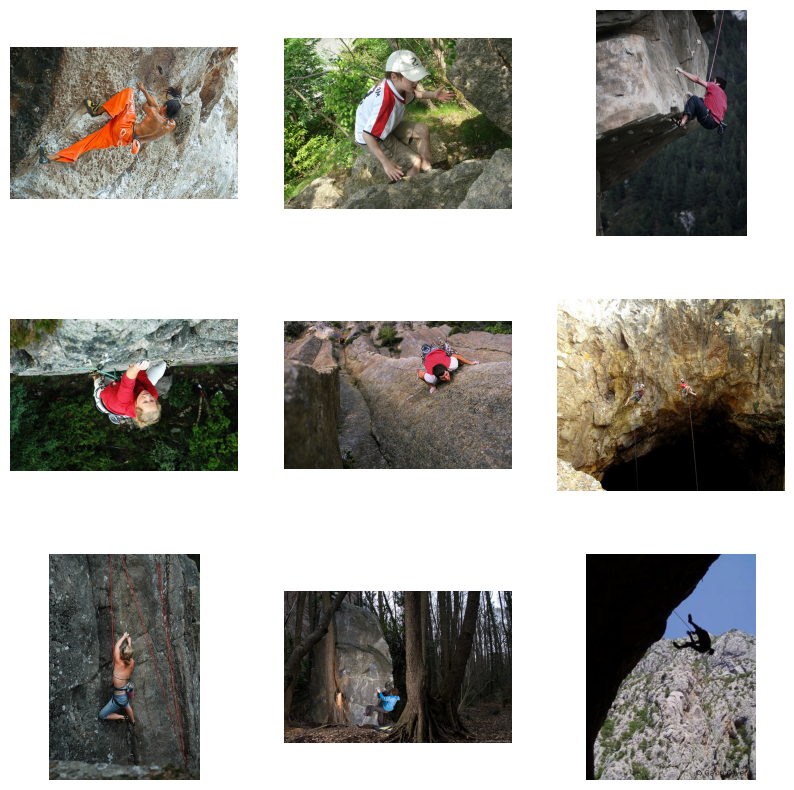

In [43]:
find_matches(model,
             image_embeddings,
             query="A rock climber in a red shirt",
             image_filenames=valid_df['image'].values,
             n=9)

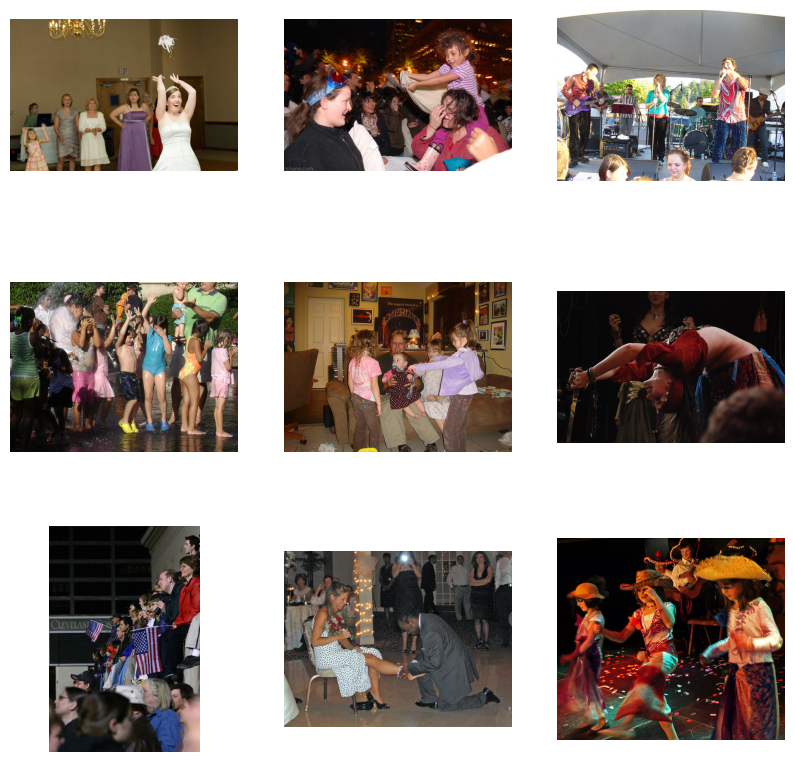

In [44]:
find_matches(model,
             image_embeddings,
             query="a group of people dancing in a party",
             image_filenames=valid_df['image'].values,
             n=9)

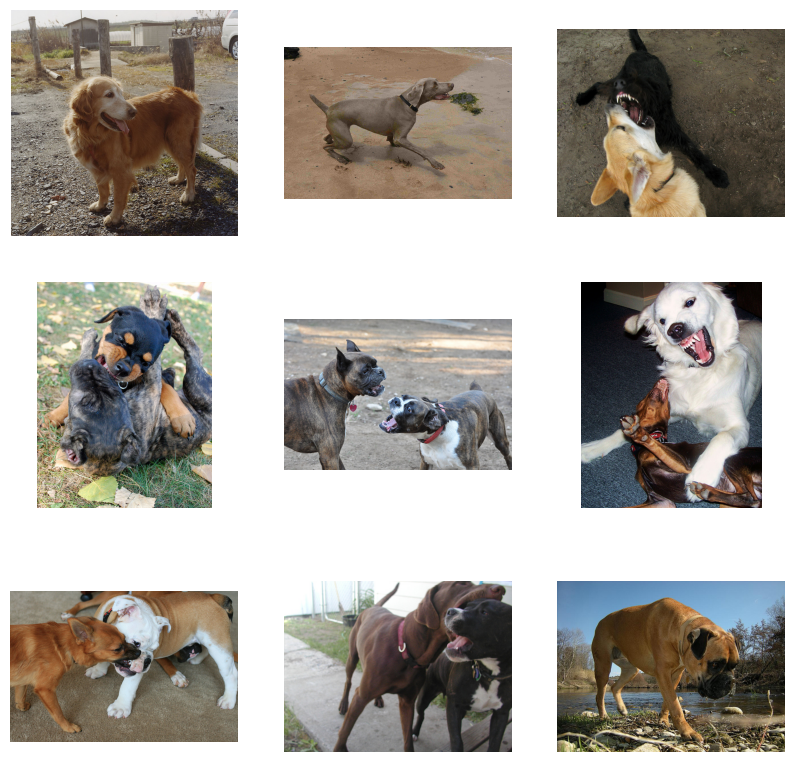

In [45]:
find_matches(model,
             image_embeddings,
             query="This is a dog",
             image_filenames=valid_df['image'].values,
             n=9)

# CIFAR10

In [5]:
!pip install openai-clip

In [2]:
import os
import clip
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from tqdm import tqdm

In [7]:
# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

# Load the dataset
root = os.path.expanduser("~/.cache")
train = CIFAR10(root, download=True, train=True, transform=preprocess)
test = CIFAR10(root, download=True, train=False, transform=preprocess)

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 127MiB/s]


100%|██████████| 170498071/170498071 [00:03<00:00, 42651956.31it/s]


Extracting /root/.cache/cifar-10-python.tar.gz to /root/.cache
Files already downloaded and verified


In [ ]:
# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('RN50', device)

# Load the dataset
root = os.path.expanduser("~/.cache")
train = CIFAR10(root, download=True, train=True, transform=preprocess)
test = CIFAR10(root, download=True, train=False, transform=preprocess)

100%|███████████████████████████████████████| 244M/244M [00:11<00:00, 22.9MiB/s]


100%|██████████| 170498071/170498071 [00:05<00:00, 28470343.72it/s]


Extracting /root/.cache/cifar-10-python.tar.gz to /root/.cache
Files already downloaded and verified


In [ ]:
def get_features(dataset):
    all_features = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(DataLoader(dataset, batch_size=100)):
            features = model.encode_image(images.to(device))
            all_features.append(features)
            all_labels.append(labels)

    return torch.cat(all_features), torch.cat(all_labels)

# Calculate the image features
train_features, train_labels = get_features(train)
test_features, test_labels = get_features(test)

100%|██████████| 100/100 [00:21<00:00,  4.67it/s]


In [27]:
# ViT-B/32
# Define a simple FFNN for classification
class SimpleFFNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleFFNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x.to(torch.float32)))
        x = self.fc2(x)
        return x

# Initialize the FFNN model
input_size = train_features.shape[1]
num_classes = 10
cnn_model = SimpleFFNN(input_size, num_classes).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

# Training the FFNN model
num_epochs = 10
batch_size = 64

train_dataset = torch.utils.data.TensorDataset(train_features, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    for inputs, labels in tqdm(train_loader):
        optimizer.zero_grad()
        outputs = cnn_model(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

# Evaluate using the FFNN model
test_dataset = torch.utils.data.TensorDataset(test_features, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

with torch.no_grad():
    cnn_model.eval()
    correct = 0
    total = 0
    for inputs, labels in tqdm(test_loader):
        outputs = cnn_model(inputs.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

accuracy = correct / total * 100.0
print(f"Accuracy = {accuracy:.3f}%")

100%|██████████| 157/157 [00:00<00:00, 605.56it/s]

Accuracy = 94.780%


In [ ]:
# RN50
# Define a simple FFNN for classification
class SimpleFFNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleFFNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x.to(torch.float32)))
        x = self.fc2(x)
        return x

# Initialize the FFNN model
input_size = train_features.shape[1]
num_classes = 10
cnn_model = SimpleFFNN(input_size, num_classes).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

# Training the FFNN model
num_epochs = 10
batch_size = 64

train_dataset = torch.utils.data.TensorDataset(train_features, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    for inputs, labels in tqdm(train_loader):
        optimizer.zero_grad()
        outputs = cnn_model(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

# Evaluate using the FFNN model
test_dataset = torch.utils.data.TensorDataset(test_features, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

with torch.no_grad():
    cnn_model.eval()
    correct = 0
    total = 0
    for inputs, labels in tqdm(test_loader):
        outputs = cnn_model(inputs.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

accuracy = correct / total * 100.0
print(f"Accuracy = {accuracy:.3f}%")

100%|██████████| 157/157 [00:00<00:00, 1145.84it/s]

Accuracy = 89.180%
